In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
import pandas as pd
import cv2

In [3]:
# custom dataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, filepath, train=True, transform=None):
        
        label_csv = pd.read_csv(Path(filepath) / 'labels.csv')
        data_split = label_csv[label_csv['train'] == train]
                
        imgs = []
        for i, spot in data_split.iterrows():
            if spot["label"] == "-":
                continue
            img = cv2.imread(spot["filepath"])
            imgs.append(img[..., 0].reshape(1, 48, 48) / 255.0)
        
        data_points = data_split[data_split["label"] != "-"]
        labels = np.array([int(label) for label in data_points["label"]])
                
        self.data = torch.tensor(np.array(imgs), dtype=torch.float32)
        self.target = torch.tensor(labels - 1, dtype=torch.long)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx], self.target[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
fp = Path(r"D:\Tracking\NucleiTracking\data\processed\embryo018")
train_dataset = CustomDataset(fp)
test_dataset = CustomDataset(fp, train=False)

In [4]:
# basic transforms
from torchvision.transforms import v2
from torchvision.transforms import functional as F

n_classes = 5
   
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        image, target = sample
        return F.normalize(image, self.mean, self.std), target

class OneHot(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        
    def __call__(self, sample):
        image, target = sample
        return image, torch.nn.functional.one_hot(target, self.n_classes)


test_transform = v2.Compose([
    Normalize((0.5,), (0.5,))
])

train_transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    Normalize((0.5,), (0.5,))
])

train_dataset = CustomDataset(fp, transform=train_transform)
test_dataset = CustomDataset(fp, train=False, transform=test_transform)

In [5]:
# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

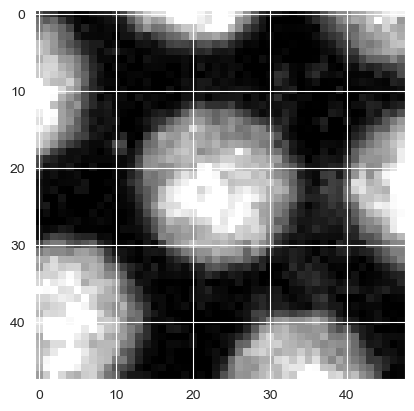

tensor(1)


In [6]:
# visualise
import matplotlib.pyplot as plt

def imshow(img, ax=None):
    img = img / 2 + 0.5
    
    npimg = img.numpy()
    if ax:
        ax.imshow(npimg[0], cmap='gray')
        return
    plt.imshow(npimg[0], cmap='gray')
    plt.show()
    
dataiter = iter(train_loader)

images, labels = list(dataiter)[0]

imshow(images[0])
print(labels[0])

In [7]:
# input shape: (batch_size, 1, 48, 48)

# set up cnn
# four layers of downsampling, with increasing number of filters
# followed by two fully connected layers

filters = [16, 32, 64, 128]
n_classes = 5

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, filters[0], 3, padding=1)
        self.convs = nn.ModuleList([nn.Conv2d(filters[i], filters[i+1], 3, padding=1) for i in range(len(filters)-1)])
        self.fc1 = nn.Linear(128*6*6, 64)
        self.fc2 = nn.Linear(64, n_classes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        for conv in self.convs:
            x = self.relu(conv(x))
            x = self.maxpool(x)
        x = x.view(-1, 128*6*6)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = CNN() 


In [8]:
# loss and optimiser
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.25, momentum=0.01)

In [9]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = cnn(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    return running_loss

In [10]:
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    cnn.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    cnn.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = cnn(vinputs)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(cnn.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
LOSS train 25.75760853290558 valid 1.4122490882873535
EPOCH 2:
LOSS train 24.491827845573425 valid 1.4205869436264038
EPOCH 3:
LOSS train 24.301694989204407 valid 1.3352299928665161
EPOCH 4:
LOSS train 23.7315753698349 valid 1.3032166957855225
EPOCH 5:
LOSS train 22.40186357498169 valid 1.1401951313018799
EPOCH 6:
LOSS train 22.14553475379944 valid 1.2736139297485352
EPOCH 7:
LOSS train 19.712086379528046 valid 1.1833295822143555
EPOCH 8:
LOSS train 19.46465027332306 valid 1.023097038269043
EPOCH 9:
LOSS train 17.614994943141937 valid 0.8722583055496216
EPOCH 10:
LOSS train 16.773050665855408 valid 1.1192388534545898
EPOCH 11:
LOSS train 14.79586911201477 valid 1.0835987329483032
EPOCH 12:
LOSS train 14.863664090633392 valid 0.8152990341186523
EPOCH 13:
LOSS train 14.030212134122849 valid 0.7000772953033447
EPOCH 14:
LOSS train 13.52969479560852 valid 0.9034366011619568
EPOCH 15:
LOSS train 12.960362792015076 valid 0.9454082250595093
EPOCH 16:
LOSS train 11.9157634973526 valid

KeyboardInterrupt: 

In [11]:
# load best model
cnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

[[122   4   0   4   0]
 [  0  68   2   0   0]
 [  1   3  42   5   0]
 [  7   0   2  38   0]
 [  1   0   0   0   0]]


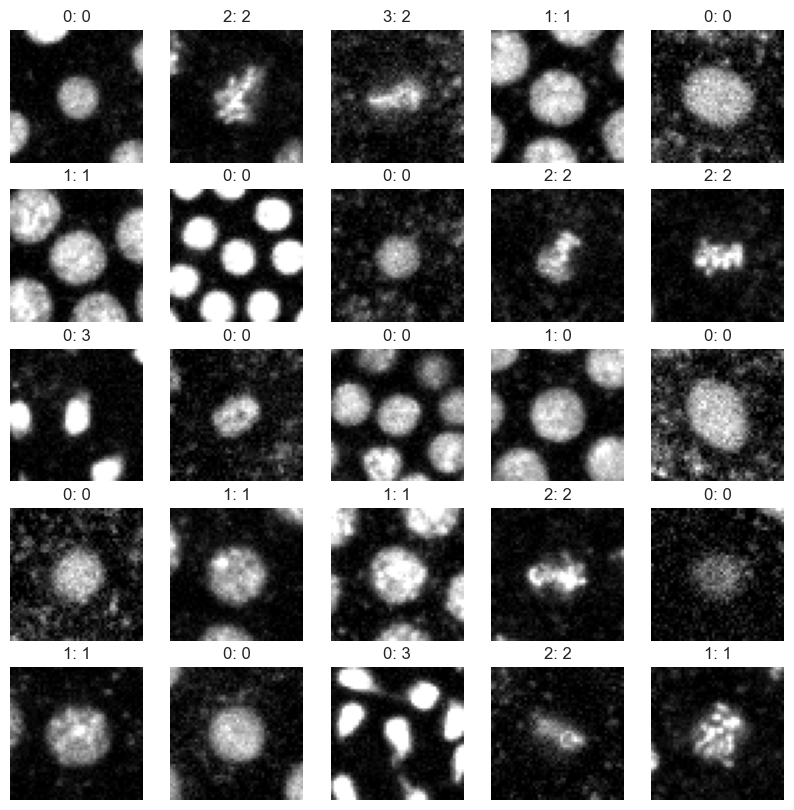

In [13]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cnn.eval()
y_pred = []
y_true = []
crops = []

with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())
        crops.extend(inputs)
        
print(confusion_matrix(y_true, y_pred))

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for crop, predicted, actual, ax in zip(crops, y_pred, y_true, axes.flatten()):
    imshow(crop, ax)
    ax.set_title(f"{predicted}: {actual}")
    ax.axis('off')

plt.show()

In [14]:
from src.utils.tracklets import import_tracklets

roots = ["embryo014a", "embryo018"]
datapath = Path().cwd().parent / "data" / "interim" / "confocal"
plotpath = datapath / "plots"
plotpath.mkdir(exist_ok=True)

spots, tracklets, metadata, tracklets_joined = import_tracklets(datapath, roots)


In [15]:
import tifffile
from tqdm import tqdm

def crop(img, y, x, size):
    return img[y - size // 2:y + size // 2, x - size // 2:x + size // 2]

for root in roots:
    rawpath = Path().cwd().parent / "data" / "interim" / "confocal" / root / f"{root}_MaxIP_bgs.tif"
    raw = tifffile.imread(rawpath)
    
    # pad 0s to raw for cropping
    raw = np.pad(raw, ((0, 0), (25, 24), (25, 24)))
    
    crops = []
    for i, spot in tqdm(spots[root].iterrows()):
        crops.append(crop(raw[int(spot["FRAME"])], int(spot["POSITION_Y"]) + 25, int(spot["POSITION_X"]) + 25, 48))
    
    crops = np.array(crops)
    crops = crops.reshape(-1, 1, 48, 48)
    crops = torch.tensor(crops, dtype=torch.float32)
    crops = F.normalize(crops, (0.5,), (0.5,))
    
    batch_size = 5_000
    
    with torch.no_grad():
        predicted_arr = []
        for i in tqdm(range(0, len(crops), batch_size)):
            outputs = cnn(crops[i:i+batch_size])
            _, predicted = torch.max(outputs, 1)
            predicted_arr.extend(predicted.numpy())
            
    spots[root]["predicted"] = predicted_arr
        



120500it [00:05, 20800.97it/s]
100%|██████████| 25/25 [01:07<00:00,  2.68s/it]
248942it [00:12, 20700.31it/s]
100%|██████████| 50/50 [02:19<00:00,  2.79s/it]


In [16]:
from skimage.draw import polygon

ft_spots = {}

for root in roots:
    spot = spots[root]
    ft_spot = spot[spot["track_n_tracklets"] == 31].copy()
    ft_spot.loc[:, "area_um"] = ft_spot["AREA"] / metadata[root]["pixels_per_um"]**2
    
    cycle = 13
    
    rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
    raw = tifffile.imread(rawfile)
    shape = raw.shape
    
    ft_spot["intensity_mean"] = 0.0
    ft_spot["intensity_std"] = 0.0
    ft_spot["intensity_varrat"] = 0.0
    
    for i, spot in tqdm(ft_spot.iterrows()):
        x, y = spot["POSITION_X"], spot["POSITION_Y"]
        t = round(spot["FRAME"])
        new_track_id = spot["track_id"]
        
        roi = [float(pt.lstrip("[ ").rstrip("] ")) for pt in spot["roi"].split(",")]
    
        xs = [round(pt + x) for pt in roi[::2]]
        ys = [round(pt + y) for pt in roi[1::2]]
    
        rr, cc = polygon(ys, xs, shape[1:])
        intensity_vals = raw[tuple([t] + [rr, cc])]
        
        # take variance ratio of intensity vals 
        ft_spot.loc[i, "intensity_mean"] = intensity_vals.mean()
        ft_spot.loc[i, "intensity_std"] = intensity_vals.std()
        ft_spot.loc[i, "intensity_stdrat"] = intensity_vals.std() / intensity_vals.mean()
        
    ft_spots[root] = ft_spot

61385it [00:30, 2033.90it/s]
139063it [01:09, 1987.67it/s]


In [17]:
print(spots["embryo018"]["predicted"])

0         0
1         2
2         3
3         3
4         3
         ..
248937    0
248938    0
248939    0
248940    0
248941    0
Name: predicted, Length: 248942, dtype: int64


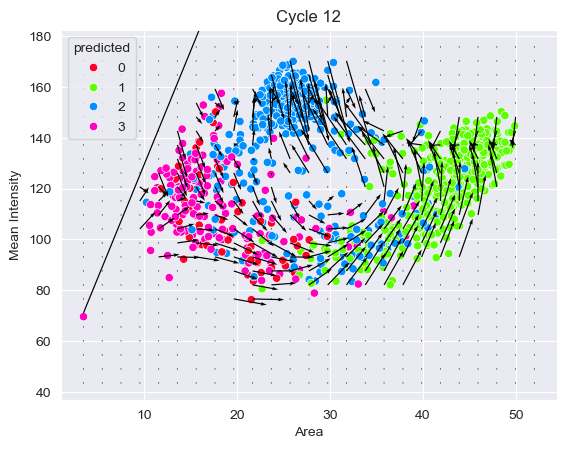

In [22]:
from scipy.spatial.distance import cdist
import seaborn as sns

cycle = 12
root = "embryo018"

ft_spot = ft_spots[root]
spot_cycle = ft_spot[ft_spot["cycle"]==cycle].copy()

spot_cycle["intensity_next"] = spot_cycle["daughter_id"].map(spot_cycle.set_index("ID")["intensity_mean"]) - spot_cycle["intensity_mean"]
spot_cycle["area_next"] = spot_cycle["daughter_id"].map(spot_cycle.set_index("ID")["area_um"]) - spot_cycle["area_um"]

sample = spot_cycle.sample(1000)
sample = sample.dropna()

x_min, x_max = spot_cycle["area_um"].min(), spot_cycle["area_um"].max()
y_min, y_max = spot_cycle["intensity_mean"].min(), spot_cycle["intensity_mean"].max()
k = 25
xy, yx = np.meshgrid(np.linspace(x_min, x_max, k), np.linspace(y_min, y_max, k))
dis = cdist(sample[["area_um", "intensity_mean"]], np.c_[xy.ravel(), yx.ravel()])
weight = np.exp(-dis**2 / 8**2)
weightsum = weight.sum(axis=0)
weight = weight / weight.sum(axis=0)

# multiply each weight by the intensity_next
intensity_next = np.dot(sample["intensity_next"], weight)
area_next = np.dot(sample["area_next"], weight)

threshold = 2
intensity_next[dis.min(axis=0) > threshold] = 0
area_next[dis.min(axis=0) > threshold] = 0
# plt.hist(dis.min(axis=0), bins=25)
# plt.show()

fig, ax = plt.subplots()
sns.scatterplot(sample, x="area_um", y="intensity_mean", hue="predicted", palette="gist_rainbow", ax=ax)
plt.quiver(xy, yx, area_next, intensity_next)
plt.title(f"Cycle {cycle}")
plt.xlabel("Area")
plt.ylabel("Mean Intensity")
plt.savefig(plotpath / f"cycle_{cycle}_intensity_quiver.png")
plt.show()

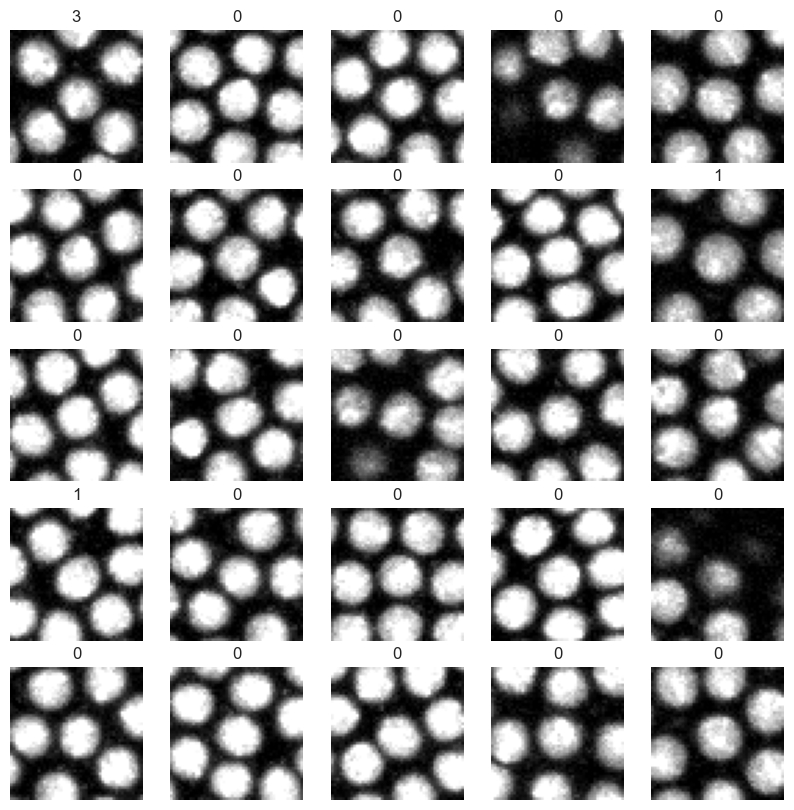

In [19]:
# visualize predictions

fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for crop, predicted, ax in zip(crops[-50:], predicted_arr[-50:], axes.flatten()):
    imshow(crop, ax)
    ax.set_title(predicted)
    ax.axis('off')

plt.show()